# Média de deslocamento por distrito - OD

Nesse notebook vamos obter a média de deslocamento por distrito de São Paulo segundo a pesquisa origem-destino do metrô, realizada em 2017. O ideal seria termos a pesquisa para o ano de 2013, mas 2017 é o mais próximo (o outro é 2007), e temos o shapefile para esse ano.





In [1]:
import pandas as pd
import os
from dbfread import DBF
import matplotlib.pyplot as plt

from core.utils.file_path import solve_path, list_files_recursive
from core.config import OD_DATA_FOLDER, SHP_FOLDER, GENERATED_DATA_FOLDER

In [2]:
od_path = solve_path('OD-2017', parent=OD_DATA_FOLDER)

In [3]:
os.listdir(od_path)

['Banco de Dados-OD2017',
 'Mapas-OD2017',
 'Manual-OD2017',
 'Tabelas-OD2017',
 'CONTEΘDO DOS DIRETαRIOS - OD2017.docx']

In [4]:
dados_od = solve_path('Banco de Dados-OD2017', parent=od_path)

In [5]:
os.listdir(dados_od)

['OD_2017_v1.sav',
 'LAYOUT OD2017_v1.xlsx',
 'VARI╡VEIS OD2017_v1.docx',
 'CORRESPOND╥NCIA ENTRE ZONAS 2007 e 2017.xlsx',
 'OD_2017_v1.dbf']

In [6]:
bd_od = solve_path('OD_2017_v1.dbf', dados_od)

In [7]:
dbf = DBF(bd_od, load=True)

In [8]:
len(dbf.records)

183092

In [9]:
dbf.records[0]

OrderedDict([('ZONA', 1),
             ('MUNI_DOM', 36),
             ('CO_DOM_X', 333743),
             ('CO_DOM_Y', 7394463),
             ('ID_DOM', '00010001'),
             ('F_DOM', 1),
             ('FE_DOM', 15.416667),
             ('DOM', 1),
             ('CD_ENTRE', 1),
             ('DATA', '06092017'),
             ('TIPO_DOM', 1),
             ('AGUA', 1),
             ('RUA_PAVI', 1),
             ('NO_MORAD', 2),
             ('TOT_FAM', 1),
             ('ID_FAM', '000100011'),
             ('F_FAM', 1),
             ('FE_FAM', 15.416667),
             ('FAMILIA', 1),
             ('NO_MORAF', 2),
             ('CONDMORA', 2),
             ('QT_BANHO', 1),
             ('QT_EMPRE', 0),
             ('QT_AUTO', 0),
             ('QT_MICRO', 1),
             ('QT_LAVALOU', 0),
             ('QT_GEL1', 0),
             ('QT_GEL2', 1),
             ('QT_FREEZ', 1),
             ('QT_MLAVA', 1),
             ('QT_DVD', 1),
             ('QT_MICROON', 1),
             ('QT_

In [10]:
def origem_sp(record):
    
    return record['MUNI_O']==36

In [11]:
def desloc_ao_trabalho(record):
    
    codigos = {1,2,3,9}
    
    return record['MOTIVO_D'] in codigos

In [12]:
def selecionar_colunas(record):
    
    colunas = [
    'ZONA_O', #zona de origem
    'MUNI_O', #municipio origem
    'ZONA_D', #zona destino
    'MUNI_D', #municipio destino
    'MOTIVO_D', #motivo no destino da viagem
    'DURACAO', #duracao da viagem em minutos
    ]
    
    return {col : record[col] for col in colunas}

In [13]:
def de_para_motivo(record):
    
    motivos_trabalho = {
        1 : 'Trabalho Indústria',
        2 : 'Trabalho Comércio',
        3 : 'Trabalho Serviços',
        9 : 'Procurar Emprego'
    }
    
    cod = record['MOTIVO_D'] 
    record['MOTIVO_D'] = motivos_trabalho[cod]

In [14]:
def filtrar_registros(dbf):
    
    filtrados = []
    
    for rec in dbf.records:
        if origem_sp(rec) and desloc_ao_trabalho(rec):
            rec = selecionar_colunas(rec)
            de_para_motivo(rec)
            filtrados.append(rec)
    return filtrados

In [15]:
dados = filtrar_registros(dbf)

In [16]:
len(dados)/len(dbf.records)

0.15629301116378652

In [17]:
del dbf #liberar memoria

In [18]:
df = pd.DataFrame(dados)

In [19]:
df.head()

,ZONA_O,MUNI_O,ZONA_D,MUNI_D,MOTIVO_D,DURACAO
0,1,36,3,36,Trabalho Serviços,10
1,1,36,82,36,Trabalho Serviços,50
2,1,36,1,36,Trabalho Comércio,10
3,1,36,1,36,Trabalho Comércio,10
4,1,36,1,36,Trabalho Comércio,10


#### Agrupar por distritos

Agora que identificamos as viagens relevantes, precisamos agrupar por distritos.

Para isso, teremos que nos valor dos dados georreferenciados das zonas OD e dos shape dos distritos de SP (a pesquisa OD tem um dado de distrito, mas não temos garantias que eles coincidem com os distritos oficiais de SP, então vamos usar os mapas oficiais, mais seguros).

In [20]:
import geopandas as gpd

/home/h-pgy/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [21]:
od_path = solve_path('zonas_OD_2017', SHP_FOLDER)
shp_od = list_files_recursive(od_path, '.shp')[0]
shp_od = gpd.read_file(shp_od)
shp_od = shp_od.set_crs(epsg = 31983)


In [22]:
distritos_path = solve_path('distritos', SHP_FOLDER)
shp_dist = list_files_recursive(distritos_path, '.shp')[0]
shp_dist = gpd.read_file(shp_dist)
shp_dist = shp_dist.set_crs(epsg = 31983)


<AxesSubplot:>

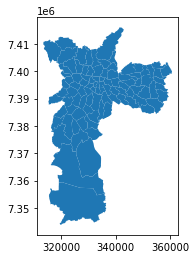

In [23]:
shp_dist.plot()

<AxesSubplot:>

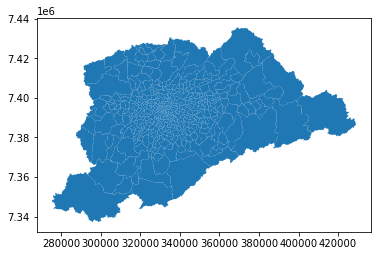

In [24]:
shp_od.plot()

Pegar apenas zonas do municipio de sp

In [25]:
shp_od = shp_od[shp_od['od_municip']=='36'].copy()

<AxesSubplot:>

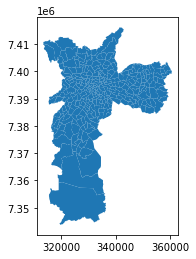

In [26]:
shp_od.plot()

Como há diferenças entre os desenhos, vou pegar o centroid do distrito.

E então vou pegar a zona mais próxima do centroide do distrito.

In [27]:
pols_dist = shp_dist.geometry
shp_dist['geometry'] = shp_dist.geometry.centroid

In [28]:
merged = gpd.sjoin_nearest(shp_od, shp_dist, how='left')

In [29]:
merged.head()

,od_id,od_nome,od_area,od_ano,od_municip,geometry,index_right,ds_nome,ds_codigo,ds_cd_sub,ds_subpref,ds_sigla,ds_areamt,ds_areakm
0,1,Sé,57.10,2017,36,"POLYGON ((333700.651 7394607.628, 333753.675 7...",26,SE,78,09,SE,SEE,2193819.874,2.194
1,2,Parque Dom Pedro,113.64,2017,36,"POLYGON ((333067.381 7395413.270, 333081.326 7...",26,SE,78,09,SE,SEE,2193819.874,2.194
2,3,Praça João Mendes,47.75,2017,36,"POLYGON ((333314.447 7393920.945, 333199.280 7...",17,REPUBLICA,66,09,SE,REP,2396993.441,2.397
3,4,Ladeira da Memória,75.11,2017,36,"POLYGON ((332703.855 7394783.117, 332703.772 7...",17,REPUBLICA,66,09,SE,REP,2396993.441,2.397
4,5,República,74.95,2017,36,"POLYGON ((332945.197 7395250.368, 332965.475 7...",17,REPUBLICA,66,09,SE,REP,2396993.441,2.397


In [30]:
merged['od_id'].duplicated().any()

False

In [31]:
cols = ['od_id', 'od_nome', 'ds_subpref' , 'ds_sigla', 'ds_nome']

In [32]:
de_para_zona_dist = merged[cols].copy()

In [33]:
merged.area.sum()/pols_dist.area.sum()

0.995883086274922

<AxesSubplot:>

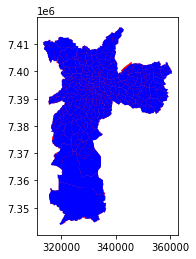

In [34]:
fig, ax = plt.subplots()
pols_dist.plot(ax=ax, color='red')
merged.plot(ax=ax, color='blue')

In [35]:
de_para_zona_dist['od_id'] = de_para_zona_dist['od_id'].astype(str)

In [36]:
df['ZONA_O'] = df['ZONA_O'].astype(str)

In [37]:
viagens_com_distrito = pd.merge(df, de_para_zona_dist, how = 'left', 
                                left_on='ZONA_O', right_on='od_id')

In [38]:
viagens_com_distrito.sample()

,ZONA_O,MUNI_O,ZONA_D,MUNI_D,MOTIVO_D,DURACAO,od_id,od_nome,ds_subpref,ds_sigla,ds_nome
23938,300,36,70,36,Trabalho Indústria,50,300,Granja Julieta,SANTO AMARO,SAM,SANTO AMARO


In [39]:
viagens_com_distrito.rename({'ds_sigla' : 'ds_origem_sigla',
                            'ds_nome' : 'ds_origem_nome'}, axis=1, inplace=True)

In [40]:
viagens_com_distrito.columns

Index(['ZONA_O', 'MUNI_O', 'ZONA_D', 'MUNI_D', 'MOTIVO_D', 'DURACAO', 'od_id',
       'od_nome', 'ds_subpref', 'ds_origem_sigla', 'ds_origem_nome'],
      dtype='object')

In [41]:
dropar = ['ZONA_O', 'MUNI_O', 'od_id','od_nome', 'ds_subpref']

In [42]:
viagens_com_distrito.drop(dropar, axis=1, inplace=True)

In [43]:
viagens_com_distrito['ZONA_D'] = viagens_com_distrito['ZONA_D'].astype(str)

In [44]:
viagens_com_distrito = viagens_com_distrito.merge(de_para_zona_dist, how='left',
                         left_on='ZONA_D', right_on='od_id')

In [45]:
viagens_com_distrito.rename({'ds_sigla' : 'ds_destino_sigla',
                            'ds_nome' : 'ds_destino_nome'}, axis=1, inplace=True)

In [46]:
viagens_com_distrito['ds_destino_nome'].isnull().any()

True

In [47]:
viagens_com_distrito['ds_destino_nome'].isnull().sum()

1663

In [48]:
viagens_com_distrito['ds_destino_nome'].fillna('Fora São Paulo', inplace=True)
viagens_com_distrito['ds_destino_sigla'].fillna('fora_sp', inplace=True)

In [49]:
viagens_com_distrito[viagens_com_distrito['MUNI_D']!=36]['ds_destino_sigla'].unique()

array(['fora_sp'], dtype=object)

In [50]:
dropar = ['ZONA_D', 'MUNI_D', 'od_id', 'od_nome', 'ds_subpref']
viagens_com_distrito.drop(dropar,axis=1, inplace=True)

In [51]:
viagens_com_distrito.head()

,MOTIVO_D,DURACAO,ds_origem_sigla,ds_origem_nome,ds_destino_sigla,ds_destino_nome
0,Trabalho Serviços,10,SEE,SE,REP,REPUBLICA
1,Trabalho Serviços,50,SEE,SE,PIN,PINHEIROS
2,Trabalho Comércio,10,SEE,SE,SEE,SE
3,Trabalho Comércio,10,SEE,SE,SEE,SE
4,Trabalho Comércio,10,SEE,SE,SEE,SE


In [52]:
def get_fname(fname):
    
    fname = solve_path(fname, GENERATED_DATA_FOLDER)
    
    return fname

In [53]:
fname=get_fname('viagens_com_distrito.csv')
viagens_com_distrito.to_csv(fname, index=False, sep=';')

In [54]:
grouped_dist = viagens_com_distrito.groupby('ds_origem_nome')

In [55]:
media_duracao = grouped_dist.mean()[['DURACAO']].reset_index()

In [56]:
fname = get_fname('media_duracao_viagem_trabalho_dist.csv')
media_duracao.to_csv(fname, index=False,sep=';',encoding='utf-8',quotechar='"')

In [57]:
media_duracao.sort_values(by='DURACAO', ascending=False)

,ds_origem_nome,DURACAO
51,MARSILAC,90.567568
24,CIDADE TIRADENTES,82.651685
55,PARELHEIROS,77.745455
29,GRAJAU,77.612903
41,JARDIM ANGELA,71.537037
...,...,...
62,PINHEIROS,22.489362
56,PARI,21.708155
66,REPUBLICA,20.744493
33,ITAIM BIBI,18.867811


In [58]:
grouped_dist_pairs = viagens_com_distrito.groupby(['ds_origem_nome', 'ds_destino_nome'])

In [59]:
media_duracao_pairs = grouped_dist_pairs.mean()[['DURACAO']].reset_index()

In [60]:
media_duracao_pairs.rename({'DURACAO' : 'duracao_media'}, axis=1,
                          inplace=True)

In [61]:
fname = get_fname('media_duracao_viagem_dist_a_dist.csv')
media_duracao_pairs.to_csv(fname, index=False,sep=';',encoding='utf-8',quotechar='"')